<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/electra/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DA FARE: 
-Sistemare dataset in modo che le coppie domanda passaggio siano giuste
-Provare modello dense, senza trainare Bert

In [1]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers

from tokenizers import BertWordPieceTokenizer

!pip install transformers
import transformers
from transformers import AutoTokenizer
pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
# Huggingface bert and associated tokenizer
pretrained_model_str = "google/electra-small-discriminator"
bert_hf_layer = transformers.TFElectraModel.from_pretrained(
    pretrained_model_str, output_attentions=True)

#pretrained_model_str = "roberta-base"
#bert_hf_layer = transformers.TFRobertaModel.from_pretrained(
    #pretrained_model_str, output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)

!nvidia-smi

     |████████████████████████████████| 3.2MB 5.9MB/s 
     |████████████████████████████████| 1.9MB 5.5MB/s 
     |████████████████████████████████| 890kB 25.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0ee9064cd53e2c3e7211eee6e2e58adc7daa4ebc08caf6291b2daec3a2890b7e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.



Thu Feb 25 11:18:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    39W / 300W |    615MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+------

In [2]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-02-25 11:18:19--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M   139MB/s    in 0.2s    

2021-02-25 11:18:21 (139 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [3]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_bert = df_original.set_index('id')
df_bert = df_bert.drop(unwanted_id)
df_bert.head()

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,"(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is the Grotto at Notre Dame?,"(381, 420)",a Marian place of prayer and reflection
5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary rep

In [4]:
#@title BERT preprocessing { form-width: "25%" }
from tqdm import tqdm

def preprocess_bert(text):
    tokenized_text = tokenizer(list(text), padding="max_length", max_length=max_seq_length, truncation=True)
    return tokenized_text.input_ids

df_bert_preprocessed = df_bert.copy()
# pre-process passage and question text
print("Preprocessing passage...")
df_bert_preprocessed['passage'] = preprocess_bert(df_bert['passage'])
print("Preprocessing question...")
df_bert_preprocessed['question'] = preprocess_bert(df_bert['question'])
df_bert_preprocessed.head()

Preprocessing passage...
Preprocessing question...


,title,passage,question,answer_idx,answer_text
id,,,,,
5733be284776f41900661182,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(515, 541)",Saint Bernadette Soubirous
5733be284776f4190066117f,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2054, 2003, 1999, 2392, 1997, 1996, 10289, 8214, 2364, 2311, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(188, 213)",a copper statue of Christ
5733be284776f41900661180,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 1996, 13546, 1997, 1996, 6730, 2540, 2012, 10289, 8214, 2003, 3875, 2000, 2029, 3252, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","(279, 296)",the Main Building
5733be284776f41900661181,University_of_Notre_Dame,"[101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, ...]","[101, 2054, 2003, 1996, 24665, 23052, 2012, 10289, 8214, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [5]:
# negative mining loss oriented data loader

class IRDataset(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.uniq_passages = df_bert.loc[df.index].groupby('passage').groups

    def __len__(self):
        return len(self.uniq_passages)//self.batch_size

    def __getitem__(self, idx):
        keys = list(self.uniq_passages.keys())[idx * self.batch_size : (idx + 1) * self.batch_size]
        id = []
        for i in keys:
            id.append(np.random.choice(self.uniq_passages[i]))

        p = self.df['passage'].loc[id].tolist()
        q = self.df['question'].loc[id].tolist()

        return (np.stack(p), np.stack(q)), np.identity(self.batch_size)
        '''
        attention_mask_q = np.stack(q)
        attention_mask_q[attention_mask_q != 0] = 1
        attention_mask_p = np.stack(p)
        attention_mask_p[attention_mask_p != 0] = 1
        # if len(p) == 0 or len(q) == 0:
        #     return ([], []), []

        # original = df_bert.loc[self.df.index]
        # unique_passage = df_bert.loc[self.df.index]['passage'].unique()
        # print(unique_passage)
        notp = []
        for index in range(idx * self.batch_size,(idx + 1) * self.batch_size):
            title = self.df["title"].iloc[index]
            passage = self.df["passage"].iloc[index]
            group = self.groups[title]
            new_group = []
            for id in group:
                if self.df["passage"][id] != passage:
                    new_group.append(id)
            notp.append(self.df["passage"][np.random.choice(new_group)])
        #print(f"notp: {len(notp)}")
        #not_p = groups[]
        # DA SISTEMARE; CI POTREBBERO ESSERE ANCORA I PASSAGGI GIUSTI PERCHè SONO RIPETUTI
        all_not_p = list(range(0,idx * self.batch_size)) + list(range((idx + 1) * self.batch_size, len(self.df)))
        #print(all_not_p)
        rnd = np.random.choice(all_not_p, self.batch_size)                                #####################################################################################################
        #print(f"rnd is {rnd}")
        #notp = self.df['passage'].iloc[rnd].tolist()
        attention_mask_not_p = np.stack(notp)
        attention_mask_not_p[attention_mask_not_p != 0] = 1
        #print(f"notp is {notp}")
        y = half*[1]+half*[0]
        #print(np.stack(p+notp))
        return (np.stack(p+notp),np.vstack((attention_mask_p,attention_mask_not_p)), np.stack(q+q),np.vstack((attention_mask_q,attention_mask_q))), np.array(y)
        #y = half*[1]+half*[1]
        #return (np.stack(p+p),np.vstack((attention_mask_p,attention_mask_p)), np.stack(q+q),np.vstack((attention_mask_q,attention_mask_q))), np.array(y)
        '''
split_value = 0.1 
val_dim = int(len(df_bert_preprocessed['title'].unique()) * split_value)
val_titles = np.random.choice(df_bert_preprocessed['title'].unique(), size=val_dim, replace=False)

df_bert_val = df_bert_preprocessed[df_bert_preprocessed['title'].isin(val_titles)]
df_bert_train = df_bert_preprocessed[~(df_bert_preprocessed['title'].isin(val_titles))]

In [ ]:
seq_train = IRDataset(df_bert_train, 16)
seq_train.__getitem__(0)

((array([[ 101, 2660, 1024, ...,    0,    0,    0],
         [ 101, 2859, 1024, ...,    0,    0,    0],
         [ 101, 2605, 1024, ...,    0,    0,    0],
         ...,
         [ 101, 6504, 1024, ...,    0,    0,    0],
         [ 101, 4977, 1024, ...,    0,    0,    0],
         [ 101, 1037, 4962, ...,    0,    0,    0]]),
  array([[  101,  2073,  2001, ...,     0,     0,     0],
         [  101,  2054,  4118, ...,     0,     0,     0],
         [  101,  2073,  3295, ...,     0,     0,     0],
         ...,
         [  101,  2040,  2020, ...,     0,     0,     0],
         [  101,  2040, 11456, ...,     0,     0,     0],
         [  101,  2054,  2003, ...,     0,     0,     0]])),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [6]:
#@title model definition { form-width: "25%" }
import tensorflow as tf
from tensorflow.keras.losses import cosine_similarity, MSE, mae

input_passage_ids = tf.keras.layers.Input(batch_input_shape=(16,max_seq_length,), dtype=tf.int32, name='input_passage_ids')
input_question_ids = tf.keras.layers.Input(batch_input_shape=(16,max_seq_length,), dtype=tf.int32, name='input_question_ids')

bert_hf_layer = transformers.TFElectraModel.from_pretrained(pretrained_model_str)

passage_encoding = bert_hf_layer(input_ids=[input_passage_ids]).last_hidden_state[:,0]
question_encoding = bert_hf_layer(input_ids=[input_question_ids]).last_hidden_state[:,0]

densep = tf.keras.layers.Dense(256)
denseq = tf.keras.layers.Dense(256)

outp = densep(passage_encoding)
outq = denseq(question_encoding)

#dot = tf.keras.layers.Dot((0,0))
outdot = tf.tensordot(outp, outq, axes=(1,1))

softmax = tf.keras.layers.Softmax(axis=0)
output = softmax(outdot)

model = keras.Model(inputs=[input_passage_ids, input_question_ids], 
                    outputs=output,
                    name="BERT_IR")

model.summary(line_length=150)

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-small-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [7]:
#@title train { form-width: "25%" }

from transformers.optimization_tf import AdamWeightDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 16
epochs = 200

seq_train = IRDataset(df_bert_train, batch_size)
seq_val = IRDataset(df_bert_val, batch_size)

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
chkpt = saveDir + '/squad_check.hdf5'

es_cb = EarlyStopping(monitor='val_loss', patience=5,verbose=1, mode='auto')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)
callbacks = [es_cb, cp_cb]

ENABLE_WANDB = True        #@param {type:"boolean"}
wandb_experiment_name = "electra+dense"  #@param {type: "string"}
if ENABLE_WANDB:
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    wandb.init(project="IR", name=wandb_experiment_name)
    wandb.config.batch_size = batch_size
    wandb.config.epochs = epochs
    callbacks.append(WandbCallback(log_batch_frequency=10,
                                   save_weights_only=True))

tf.keras.backend.clear_session()

optimizer = AdamWeightDecay(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = "accuracy")
history = model.fit(seq_train, epochs=epochs,
                    callbacks=callbacks, 
                    validation_data=seq_val,
                    batch_size=batch_size)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
Aborted!
^C


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [9]:
#@title inference model { form-width: "25%" }

model.load_weights('model-best.h5')
bert_hf_layer.set_weights(model.layers[2].get_weights())
densep.set_weights(model.layers[5].get_weights())
denseq.set_weights(model.layers[6].get_weights())

input_txt_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32)
output = bert_hf_layer(input_ids=input_txt_ids).last_hidden_state[:,0]
outp = densep(output)
passage_encoder = keras.Model(inputs=input_txt_ids, outputs=outp)
outq = denseq(output)
question_encoder = keras.Model(inputs=input_txt_ids, outputs=outq)

encoded_val_passage = np.zeros((len(df_bert_val), 256))
encoded_val_question = np.zeros((len(df_bert_val), 256))
passages = np.stack(df_bert_val['passage'])
questions = np.stack(df_bert_val['question'])

for i in tqdm(range(len(df_bert_val)//batch_size)):
    encoded_val_passage[i*batch_size : (i+1)*batch_size] = passage_encoder(passages[i*batch_size : (i+1)*batch_size])
    encoded_val_question[i*batch_size : (i+1)*batch_size] = question_encoder(questions[i*batch_size : (i+1)*batch_size])

100%|██████████| 446/446 [01:03<00:00,  7.02it/s]


In [32]:
#@title kNN cosine similarity (don't work because the net is trained with dot product) { form-width: "25%" }

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

start=985
size=16

k=1
tree = NearestNeighbors(n_neighbors=k, metric='cosine')
tree.fit(encoded_val_passage[start:start+size])

results = tree.kneighbors(encoded_val_question[start:start+size], n_neighbors=k, return_distance=False)

ok=0
for i in range(len(results)):
    for j in range(k):
        if np.array_equal(passages[results[i,j]], passages[i]):
            ok+=1

ok/len(results)*100

50.0

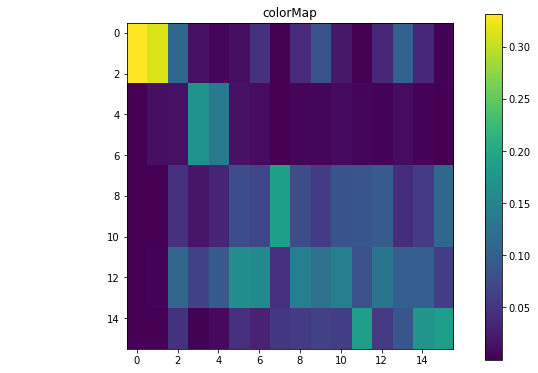

62.5

In [31]:
#@title argmax evaluation and plot { form-width: "25%" }

import matplotlib.pyplot as plt

a = tf.keras.layers.Input(shape=(256,), dtype=tf.float32)
b = tf.keras.layers.Input(shape=(256,), dtype=tf.float32)
outdot = tf.tensordot(a, b, axes=(1,1))
softmax = tf.keras.layers.Softmax(axis=0)
output = softmax(outdot)
classifier = keras.Model(inputs=[a,b], outputs=output)

start=985
size=16

pred = classifier.predict((encoded_val_passage[start:start+size], encoded_val_question[start:start+size]), 
                          batch_size=size)

#### plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(pred)
ax.set_aspect('equal')
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()
####

pred = tf.argmax(pred, axis=1)

ok=0
for i in range(len(pred)):
    if np.array_equal(passages[pred[i]], passages[i]):
        ok+=1

ok/len(pred)*100

In [ ]:
!pip3 install wikipedia-api

import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')
cat = wiki_wiki.page("Category:Physics")
print("Category members: Category:Physics")
for p in cat.categorymembers.values():
  if p.namespace == wikipediaapi.Namespace.CATEGORY:
    # it is category, so you have to make decision
    # if you want to fetch also text from pages that belong
    # to this category
    print(p)
  elif p.namespace == wikipediaapi.Namespace.MAIN:
    # it is page => we can get text
    print(p)
    print(p.text)

def print_categorymembers(categorymembers, level=0, max_level=3):
        for c in categorymembers.values():
            print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
                print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)

cat = wiki_wiki.page("Category:Artificial intelligence")
print_categorymembers(cat.categorymembers)

wiki_wiki = wikipediaapi.Wikipedia('en')

page_py = wiki_wiki.page('Python_(programming_language)')
print(page_py.text)